# HW3: Explore and Exploit for Arm-Bandit Problem

## Preparation

### Create a Python base class for K-armed bandit algorithms.

#### Prompt:

Create a Python base class for K-armed bandit algorithms that:

- Serves as a foundation for various algorithms (Epsilon-Greedy, UCB, Softmax, Thompson Sampling)
- Has default parameters:
  - 10 arms
  - 1000 iterations
- Tracks the following metrics:
  - Count of selections for each arm
  - Cumulative reward for each iteration
  - Cumulative average reward for each iteration
- Provides only the base class implementation
- Includes English comments throughout the code

Please provide the implementation with clear structure and documentation to facilitate easy extension with specific algorithms.

#### Code: 
This is the base class for the K-armed bandit, which will be used in subsequent experiments. 

In [12]:
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np

class MultiArmedBandit(ABC):
    """
    Base class for Multi-Armed Bandit problems.
    This class provides the framework for implementing different bandit algorithms.
    """
    
    def __init__(self, n_arms=10, iterations=1000, true_rewards=None):
        """
        Initialize the Multi-Armed Bandit environment.
        
        Args:
            n_arms (int): Number of arms (actions)
            iterations (int): Number of iterations to run
            true_rewards (list/array): Optional list of true reward means for each arm
        """
        self.n_arms = n_arms
        self.iterations = iterations
        
        # Initialize true reward means for each arm if not provided
        if true_rewards is None:
            self.true_rewards = np.random.normal(0, 1, n_arms)  # Random normal distribution
        else:
            self.true_rewards = true_rewards
            
        # Tracking variables
        self.arm_counts = np.zeros(n_arms)  # Count of times each arm was pulled
        self.reward_sums = np.zeros(n_arms)  # Sum of rewards for each arm
        self.cumulative_average_rewards = np.zeros(iterations)  # Cumulative average reward at each iteration
        self.cumulative_rewards = np.zeros(iterations)  # Total cumulative reward at each iteration
        self.selected_arms = []  # History of selected arms
        
    def reset(self):
        """Reset all tracking variables to start a new experiment"""
        self.arm_counts = np.zeros(self.n_arms)
        self.reward_sums = np.zeros(self.n_arms)
        self.cumulative_average_rewards = np.zeros(self.iterations)
        self.cumulative_rewards = np.zeros(self.iterations)
        self.selected_arms = []
    
    def pull_arm(self, arm_index):
        """
        Pull an arm and get its reward.
        
        Args:
            arm_index (int): The index of the arm to pull
            
        Returns:
            float: The reward from pulling the arm
        """
        # Generate reward with Gaussian noise around the true mean
        reward = np.random.normal(self.true_rewards[arm_index], 1)
        
        # Update counts and reward sums
        self.arm_counts[arm_index] += 1
        self.reward_sums[arm_index] += reward
        return reward
    
    @abstractmethod
    def select_arm(self):
        """
        Select which arm to pull next.
        This method should be implemented by subclasses with specific algorithms.
        
        Returns:
            int: The index of the selected arm
        """
        pass
    
    def run(self):
        """
        Run the bandit algorithm for the specified number of iterations.
        
        Returns:
            tuple: (cumulative_average_rewards, arm_counts, selected_arms)
        """
        self.reset()
        total_reward = 0
        
        for t in range(self.iterations):
            # Select arm according to the algorithm
            arm = self.select_arm()
            self.selected_arms.append(arm)
            
            # Pull arm and observe reward
            reward = self.pull_arm(arm)
            
            # Update cumulative reward
            total_reward += reward
            self.cumulative_rewards[t] = total_reward
            self.cumulative_average_rewards[t] = total_reward / (t + 1)
        
        return self.cumulative_rewards, self.cumulative_average_rewards, self.arm_counts, self.selected_arms
    
    def get_arm_mean_rewards(self):
        """
        Calculate the mean rewards for each arm based on observed rewards.
        
        Returns:
            array: Mean reward for each arm
        """
        mean_rewards = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            if self.arm_counts[i] > 0:
                mean_rewards[i] = self.reward_sums[i] / self.arm_counts[i]
        return mean_rewards
    
    def plot_results(self, color='blue'):
        """Plot the results of the experiment"""
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Cumulative average reward over time
        plt.subplot(2, 2, 1)
        plt.plot(self.cumulative_average_rewards, color=color)
        plt.xlabel('Iteration')
        plt.ylabel('Cumulative Average Reward')
        plt.title('Average Reward Over Time')
        
        # Plot 2: Total cumulative reward over time
        plt.subplot(2, 2, 2)
        plt.plot(self.cumulative_rewards, color=color)
        plt.xlabel('Iteration')
        plt.ylabel('Cumulative Reward')
        plt.title('Total Reward Over Time')
        
        # Plot 3: Arm selection counts
        plt.subplot(2, 2, 3)
        plt.bar(range(self.n_arms), self.arm_counts, color=color)
        plt.xlabel('Arm')
        plt.ylabel('Number of Pulls')
        plt.title('Arm Selection Frequency')
        
        plt.tight_layout()
        plt.show()

## Experiment

### Experiment settings:

In [13]:
n_arms = 10
iterations = 1000
true_rewards = np.random.normal(0, 1, n_arms)

### 1. Epsilon-Greedy

#### Prompt:

- Generate Latex code for the Epsilon-Greedy algorithm.

- Implement the Epsilon-Greedy algorithm based on the provided base class.

- Plot the average reward over time and the number of selections for each arm.

#### Latex:

<!-- ![epsilon-greedy](image/epsilon-greedy.png) -->

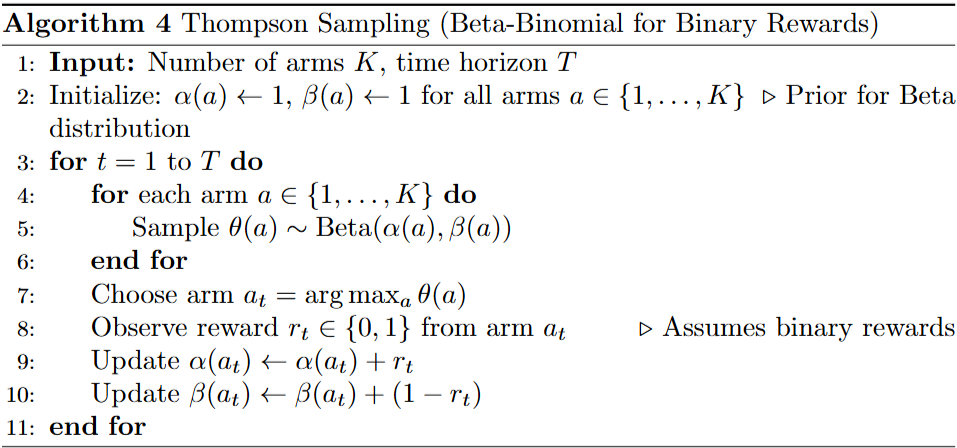

#### Code:

In [14]:
class EpsilonGreedy(MultiArmedBandit):
    """
    Implementation of Epsilon-Greedy algorithm for the Multi-Armed Bandit problem.
    
    The algorithm selects the best arm with probability (1-epsilon) and 
    explores a random arm with probability epsilon.
    """
    
    def __init__(self, n_arms=10, iterations=1000, epsilon=0.1, true_rewards=None):
        """
        Initialize the Epsilon-Greedy algorithm.
        
        Args:
            n_arms (int): Number of arms (actions)
            iterations (int): Number of iterations to run
            epsilon (float): Exploration parameter between 0 and 1
            true_rewards (list/array): Optional list of true reward means for each arm
        """
        super().__init__(n_arms, iterations, true_rewards)
        self.epsilon = epsilon
    
    def select_arm(self):
        """
        Select an arm using the Epsilon-Greedy strategy.
        
        With probability (1-epsilon), select the arm with the highest estimated mean reward.
        With probability epsilon, select a random arm.
        
        Returns:
            int: The index of the selected arm
        """
        # Exploration: select a random arm with probability epsilon
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_arms)
        
        # Exploitation: select the best arm with probability (1-epsilon)
        else:
            # For arms that haven't been tried yet, assign them a high value to ensure they get tried
            estimated_rewards = np.zeros(self.n_arms)
            for i in range(self.n_arms):
                if self.arm_counts[i] > 0:
                    estimated_rewards[i] = self.reward_sums[i] / self.arm_counts[i]
                else:
                    estimated_rewards[i] = float('inf')  # Ensure untried arms are selected first
            
            # Return the arm with the highest estimated reward
            return np.argmax(estimated_rewards)

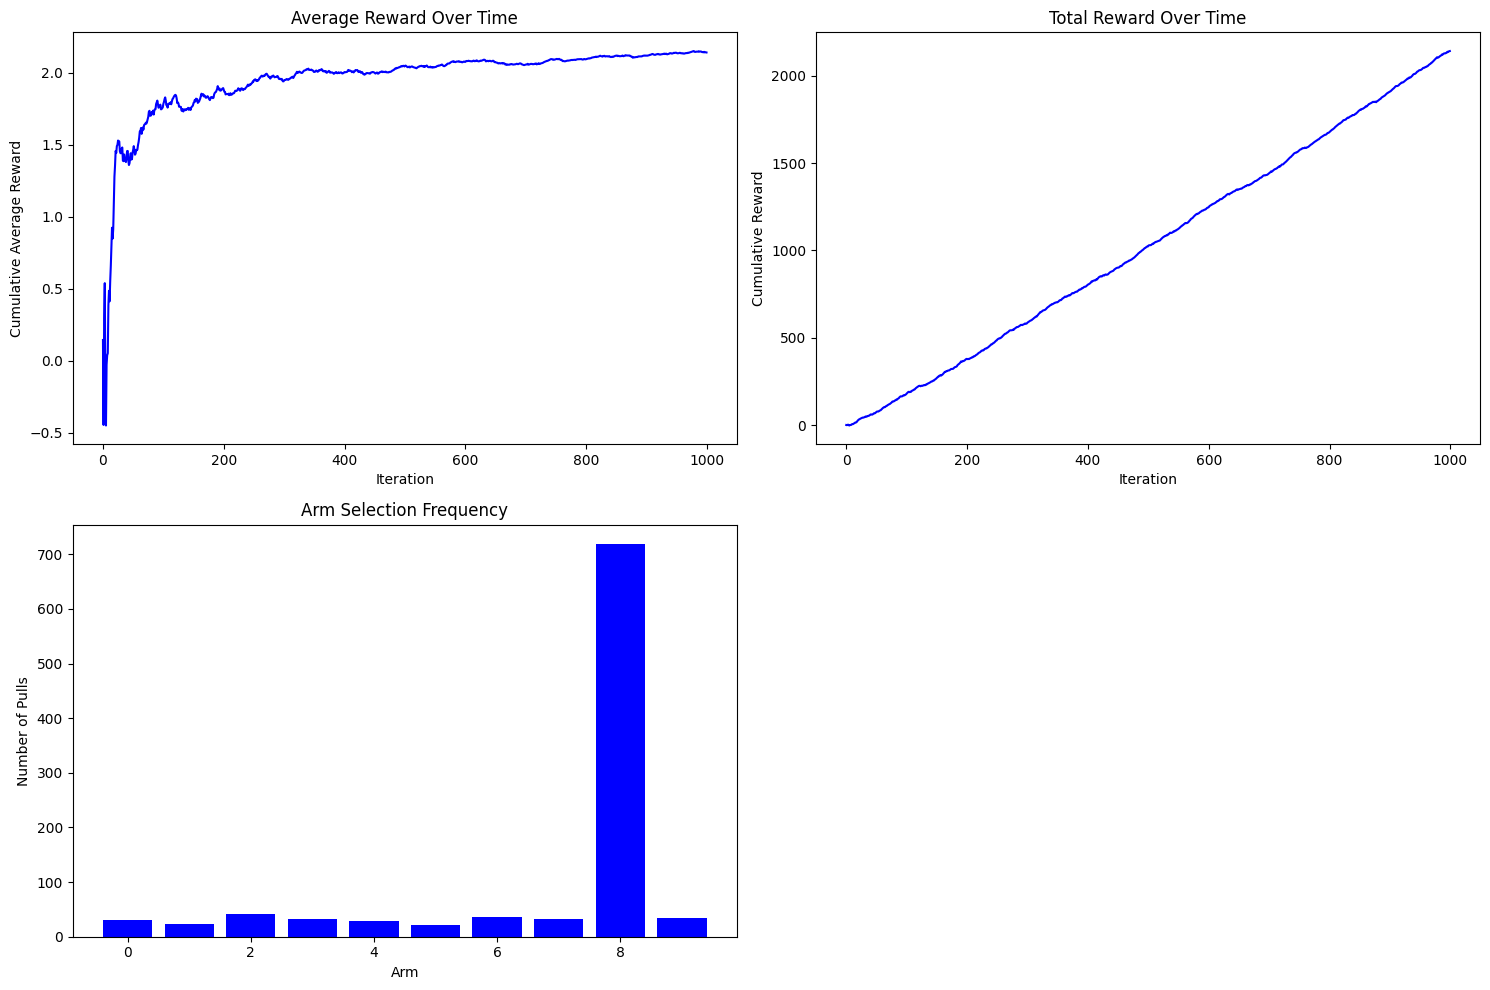

In [15]:
eg = EpsilonGreedy(n_arms=n_arms, iterations=iterations, epsilon=0.3, true_rewards=true_rewards)
eg_cumulative_rewards, eg_cumulative_average_rewards, eg_arm_counts, eg_selected_arms = eg.run()
eg.plot_results(color='blue')

### 2. UCB (Upper Confidence Bound)

#### Prompt:

- Generate Latex code for the UCB algorithm.

- Implement the UCB algorithm based on the provided base class.

- Plot the average reward over time and the number of selections for each arm.

### Latex:

<!-- ![ucb](image/ucb.png) -->

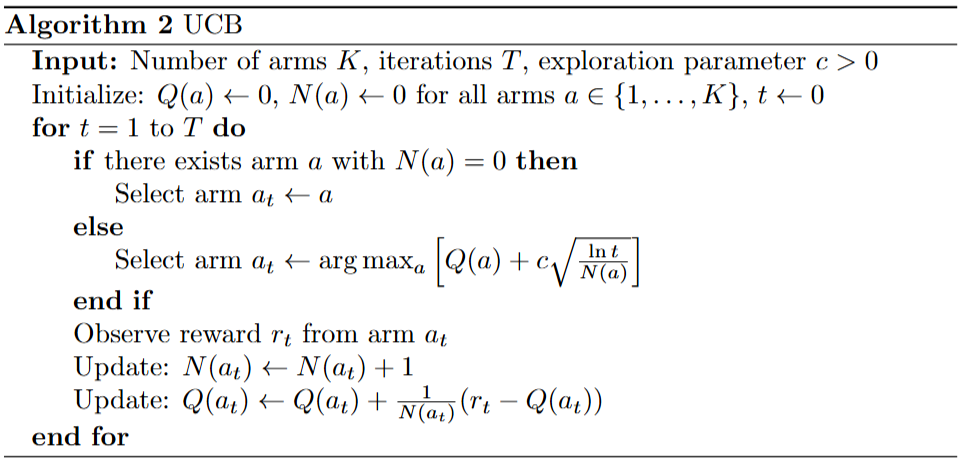

### Code:

In [16]:
import math


class UCB(MultiArmedBandit):
    """
    Implementation of Upper Confidence Bound (UCB) algorithm for the Multi-Armed Bandit problem.
    
    UCB selects actions according to:
    UCB_i = Q_i + c * sqrt(ln(t)/N_i)
    
    where:
    - Q_i: estimated reward mean for arm i
    - c: exploration parameter
    - t: total number of rounds so far
    - N_i: number of times arm i has been pulled
    """
    
    def __init__(self, n_arms=10, iterations=1000, c=2.0, true_rewards=None):
        """
        Initialize the UCB algorithm.
        
        Args:
            n_arms (int): Number of arms (actions)
            iterations (int): Number of iterations to run
            c (float): Exploration parameter controlling the confidence bounds
            true_rewards (list/array): Optional list of true reward means for each arm
        """
        super().__init__(n_arms, iterations, true_rewards)
        self.c = c
        self.t = 0  # Total number of rounds
    
    def reset(self):
        """Reset all tracking variables to start a new experiment"""
        super().reset()
        self.t = 0
    
    def select_arm(self):
        """
        Select an arm using the UCB strategy.
        
        Calculate the UCB value for each arm and select the arm with the highest value.
        For arms that haven't been tried yet, assign them a high value to ensure they get tried.
        
        Returns:
            int: The index of the selected arm
        """
        self.t += 1
        
        # First, make sure each arm is tried at least once
        for i in range(self.n_arms):
            if self.arm_counts[i] == 0:
                return i
        
        # Calculate UCB value for each arm
        ucb_values = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            # Estimated mean reward
            mean_reward = self.reward_sums[i] / self.arm_counts[i]
            
            # Exploration bonus
            exploration_bonus = self.c * math.sqrt(math.log(self.t) / self.arm_counts[i])
            
            # UCB value
            ucb_values[i] = mean_reward + exploration_bonus
        
        # Return the arm with the highest UCB value
        return np.argmax(ucb_values)

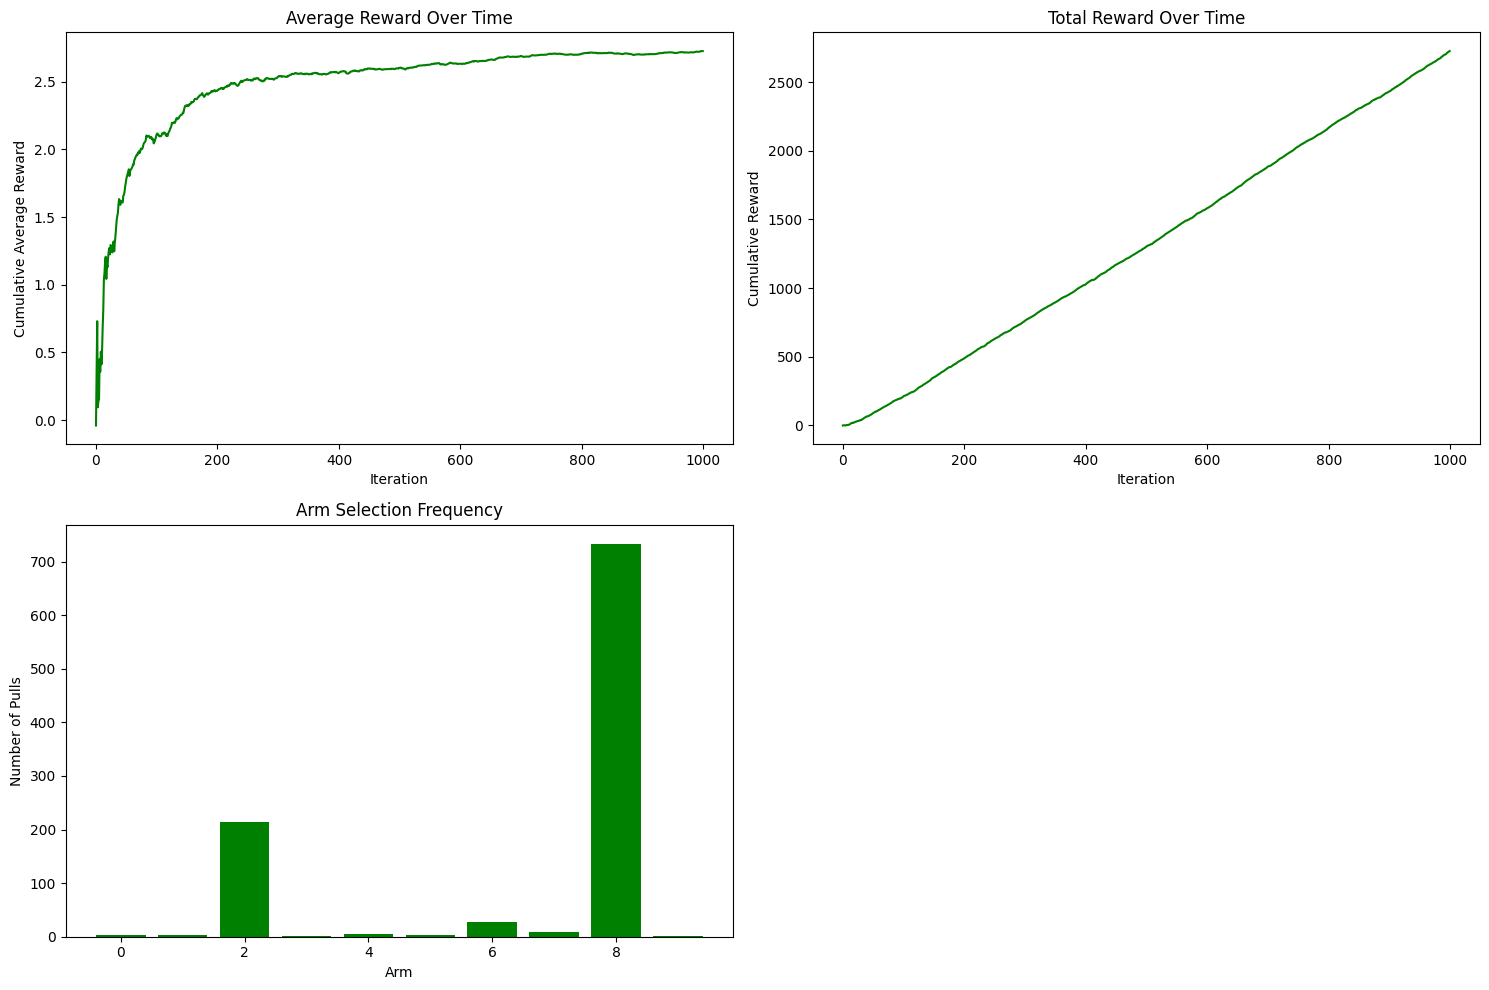

In [17]:
ucb = UCB(n_arms=n_arms, iterations=iterations, c=2.0, true_rewards=true_rewards)
ucb_cumulative_rewards, ucb_cumulative_average_rewards, ucb_arm_counts, ucb_selected_arms = ucb.run()
ucb.plot_results(color='green')

### 3. Softmax

#### Prompt:

- Generate Latex code for the Softmax algorithm.

- Implement the Softmax algorithm based on the provided base class.

- Plot the average reward over time and the number of selections for each arm.

### Latex:
<!-- ![softmax](image/softmax.png) -->

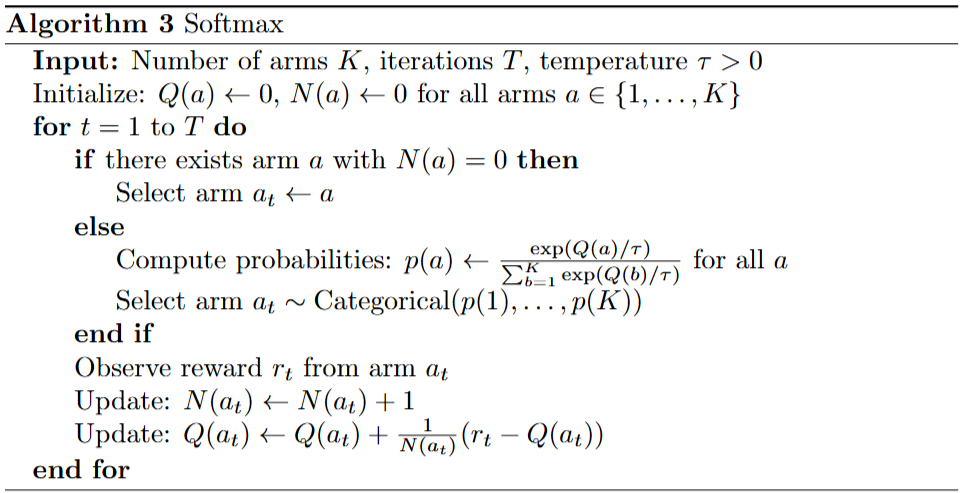

In [18]:
class Softmax(MultiArmedBandit):
    """
    Implementation of Softmax algorithm for the Multi-Armed Bandit problem.
    
    The Softmax algorithm selects arms with probability proportional to their
    exponentially weighted average rewards, controlled by a temperature parameter.
    Higher temperature leads to more exploration (more uniform probabilities).
    Lower temperature leads to more exploitation (higher probability for better arms).
    """
    
    def __init__(self, n_arms=10, iterations=1000, temperature=0.2, true_rewards=None):
        """
        Initialize the Softmax algorithm.
        
        Args:
            n_arms (int): Number of arms (actions)
            iterations (int): Number of iterations to run
            temperature (float): Temperature parameter controlling exploration
                                 Higher value = more exploration
                                 Lower value = more exploitation
            true_rewards (list/array): Optional list of true reward means for each arm
        """
        super().__init__(n_arms, iterations, true_rewards)
        self.temperature = temperature
    
    def select_arm(self):
        """
        Select an arm using the Softmax strategy.
        
        Converts the estimated mean rewards of each arm into a probability distribution
        using the softmax function, then samples an arm according to that distribution.
        
        Returns:
            int: The index of the selected arm
        """
        # First, ensure each arm is tried at least once
        for i in range(self.n_arms):
            if self.arm_counts[i] == 0:
                return i
        
        # Calculate estimated mean rewards
        estimated_rewards = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            estimated_rewards[i] = self.reward_sums[i] / self.arm_counts[i]
        
        # Apply softmax function to convert rewards to probabilities
        # To prevent overflow, subtract the maximum reward before exponentiating
        max_reward = np.max(estimated_rewards)
        exp_rewards = np.exp((estimated_rewards - max_reward) / self.temperature)
        probabilities = exp_rewards / np.sum(exp_rewards)
        
        # Sample an arm according to the calculated probabilities
        return np.random.choice(self.n_arms, p=probabilities)

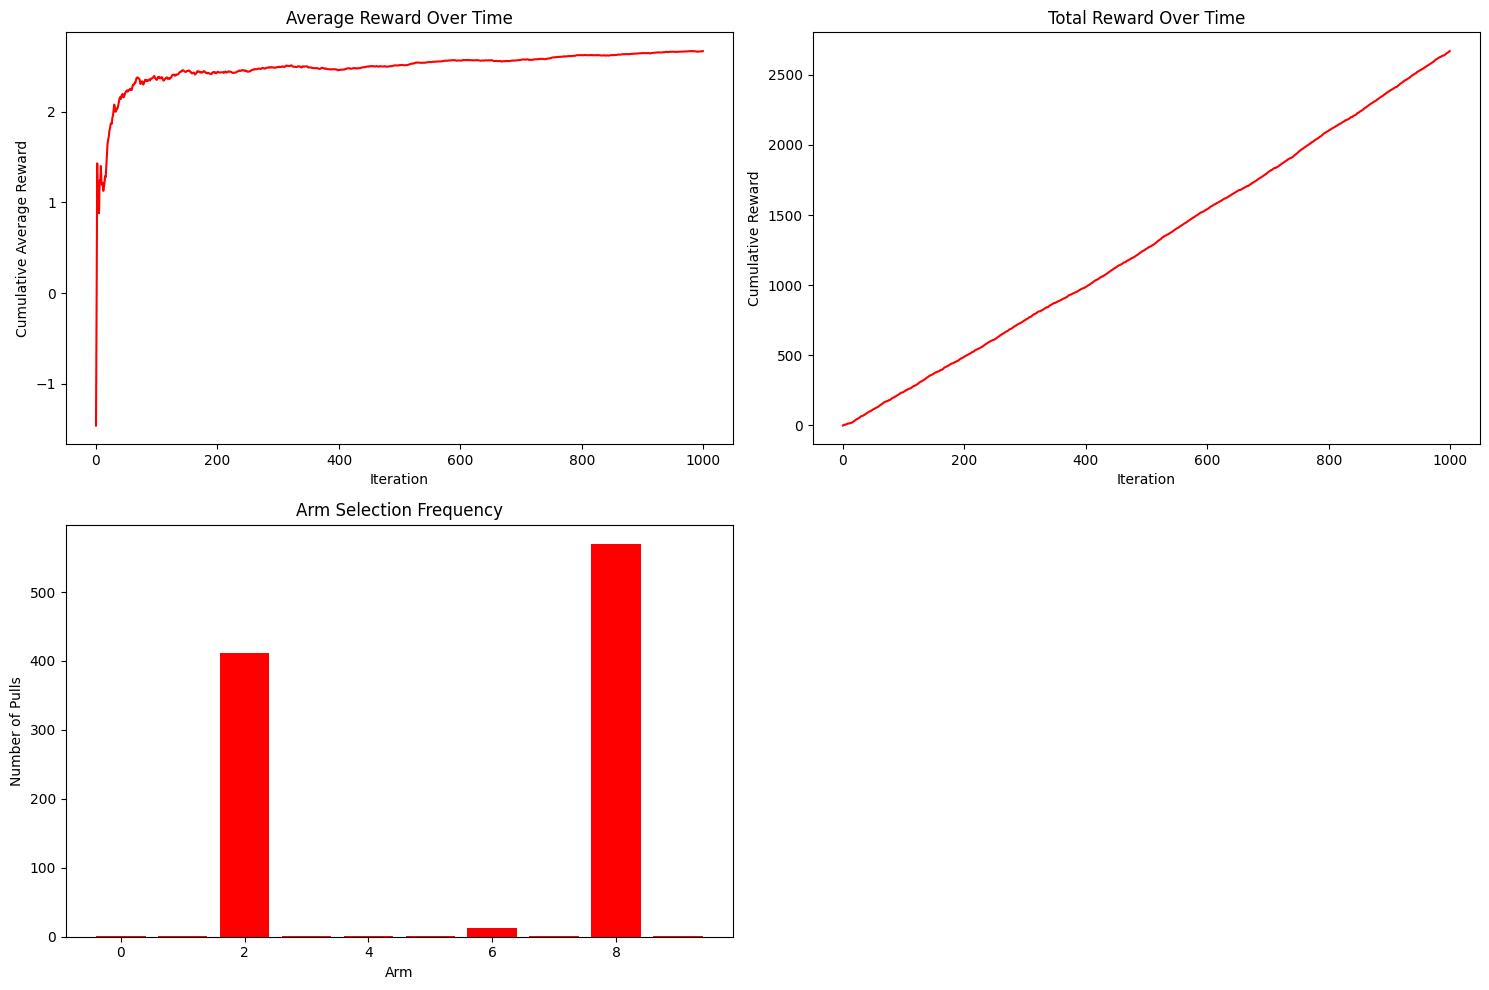

In [19]:
softmax = Softmax(n_arms=n_arms, iterations=iterations, temperature=0.2, true_rewards=true_rewards)
softmax_cumulative_rewards, softmax_cumulative_average_rewards, softmax_arm_counts, softmax_selected_arms = softmax.run()
softmax.plot_results(color='red')

### 4. Thompson Sampling

#### Prompt:

- Generate Latex code for the Thompson Sampling algorithm.

- Implement the Thompson Sampling algorithm based on the provided base class

- Plot the average reward over time and the number of selections for each arm.

### Latex:

<!-- ![thompson-sampling](image/thompson-sampling.png) -->

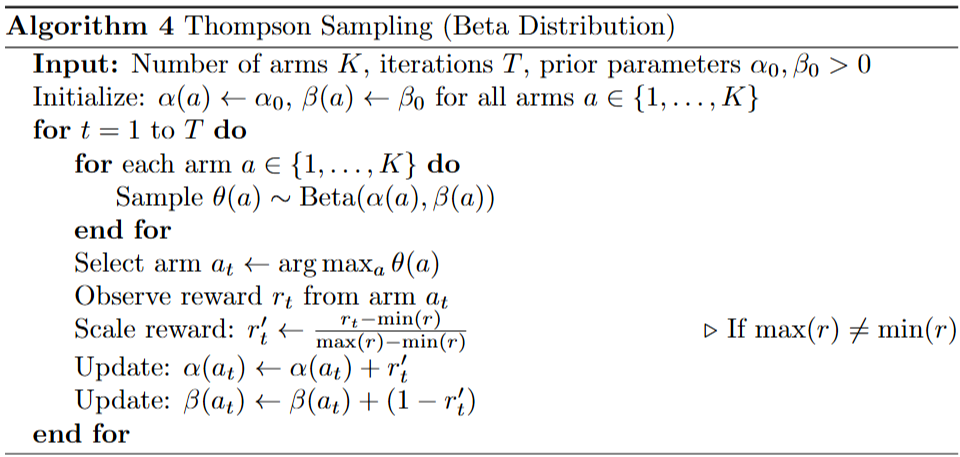

### Code:

In [20]:
class ThompsonSampling(MultiArmedBandit):
    """
    Implementation of Thompson Sampling algorithm for the Multi-Armed Bandit problem.
    
    Thompson Sampling uses Bayesian approach by maintaining a probability distribution
    over the reward for each arm. For each action, it samples from these distributions
    and selects the arm with the highest sampled value.
    
    This implementation uses Beta distributions to model the rewards for each arm,
    which is suitable for rewards in the [0,1] range. For non-binary rewards,
    the implementation scales and shifts rewards to the [0,1] interval.
    """
    
    def __init__(self, n_arms=10, iterations=1000, alpha=1.0, beta=1.0, true_rewards=None):
        """
        Initialize the Thompson Sampling algorithm.
        
        Args:
            n_arms (int): Number of arms (actions)
            iterations (int): Number of iterations to run
            alpha (float): Initial alpha parameter for Beta distribution
            beta (float): Initial beta parameter for Beta distribution
            true_rewards (list/array): Optional list of true reward means for each arm
        """
        super().__init__(n_arms, iterations, true_rewards)
        self.alpha = np.ones(n_arms) * alpha  # Success counts for each arm (prior)
        self.beta = np.ones(n_arms) * beta    # Failure counts for each arm (prior)
        
        # For scaling rewards
        self.min_reward = float('inf')
        self.max_reward = float('-inf')
    
    def reset(self):
        """Reset all tracking variables to start a new experiment"""
        super().reset()
        self.alpha = np.ones(self.n_arms) * 1.0
        self.beta = np.ones(self.n_arms) * 1.0
        self.min_reward = float('inf')
        self.max_reward = float('-inf')
    
    def pull_arm(self, arm_index):
        """
        Pull an arm and get its reward, updating the Beta distribution parameters.
        
        Args:
            arm_index (int): The index of the arm to pull
            
        Returns:
            float: The reward from pulling the arm
        """
        # Get reward from the base class method
        reward = super().pull_arm(arm_index)
        
        # Update min and max for scaling
        self.min_reward = min(self.min_reward, reward)
        self.max_reward = max(self.max_reward, reward)
        
        # Scale reward to [0, 1] if we have seen multiple rewards
        if self.min_reward < self.max_reward:
            scaled_reward = (reward - self.min_reward) / (self.max_reward - self.min_reward)
        else:
            scaled_reward = 0.5  # Default if all rewards are the same
            
        # Update Beta distribution parameters
        self.alpha[arm_index] += scaled_reward
        self.beta[arm_index] += (1.0 - scaled_reward)
        
        return reward
    
    def select_arm(self):
        """
        Select an arm using the Thompson Sampling strategy.
        
        Sample a value from the Beta distribution for each arm and select the arm
        with the highest sampled value.
        
        Returns:
            int: The index of the selected arm
        """
        # Sample a value from Beta distribution for each arm
        samples = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            samples[i] = np.random.beta(self.alpha[i], self.beta[i])
            
        # Return the arm with the highest sampled value
        return np.argmax(samples)

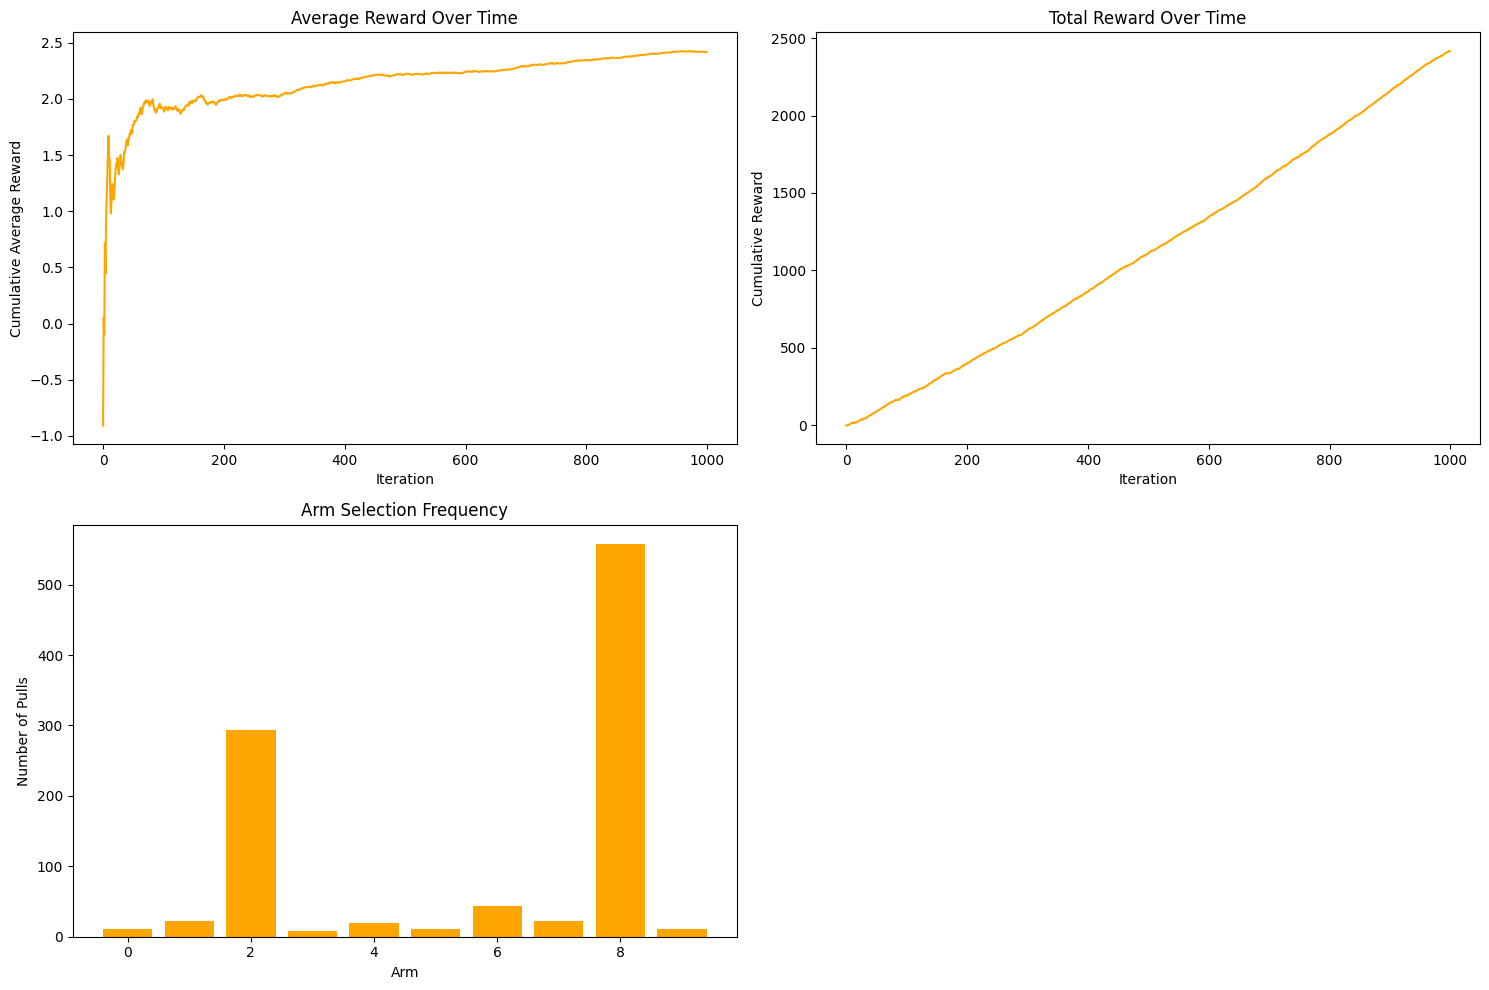

In [21]:
ts = ThompsonSampling(n_arms=n_arms, iterations=iterations, alpha=1.0, beta=1.0, true_rewards=true_rewards)
ts_cumulative_rewards, ts_cumulative_average_rewards, ts_arm_counts, ts_selected_arms = ts.run()
ts.plot_results("orange")

## Experiment Results

### Prompt:

Compare the cumulative rewards for each algorithm and plot the results.

Conduct space and time complexity analysis, explaining the performance and differences of each algorithm.

### Code:

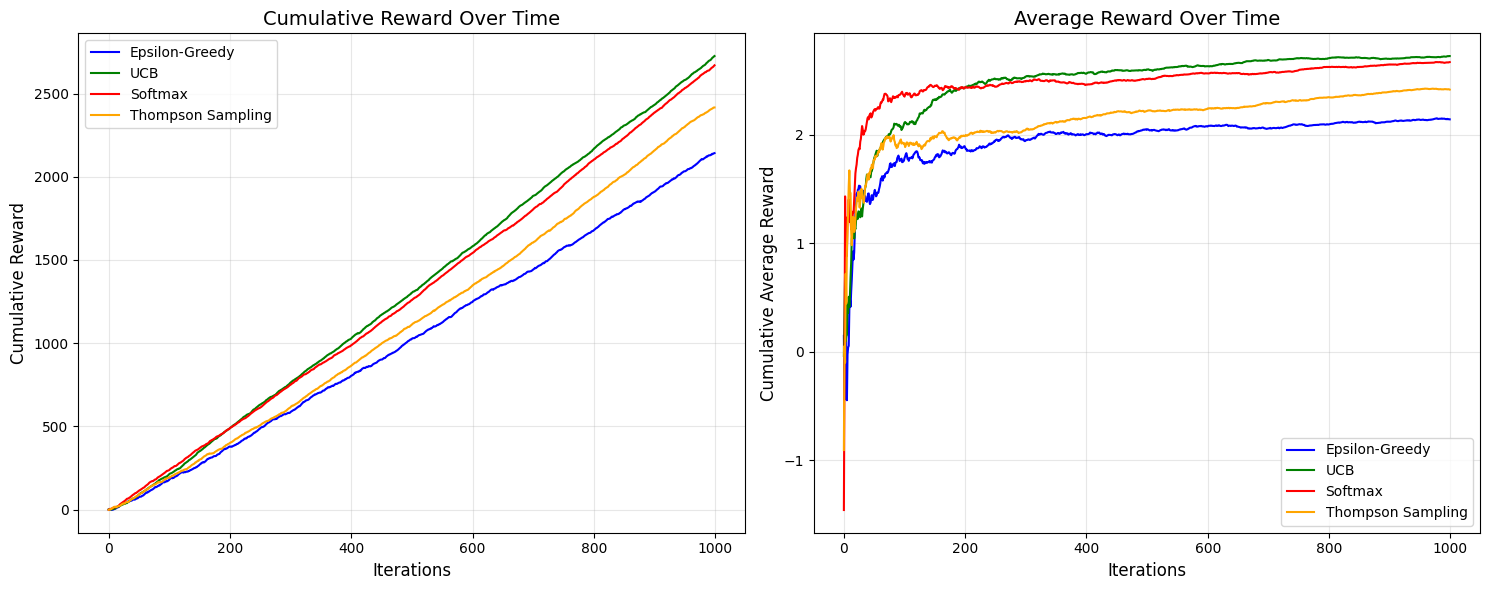

In [22]:
# Compare the cumulative_rewards of each algorithm
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left subplot: Cumulative rewards
axes[0].plot(eg_cumulative_rewards, label='Epsilon-Greedy', color='blue')
axes[0].plot(ucb_cumulative_rewards, label='UCB', color='green')
axes[0].plot(softmax_cumulative_rewards, label='Softmax', color='red')
axes[0].plot(ts_cumulative_rewards, label='Thompson Sampling', color='orange')
axes[0].set_xlabel('Iterations', fontsize=12)
axes[0].set_ylabel('Cumulative Reward', fontsize=12)
axes[0].set_title('Cumulative Reward Over Time', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right subplot: Cumulative average rewards
axes[1].plot(eg_cumulative_average_rewards, label='Epsilon-Greedy', color='blue')
axes[1].plot(ucb_cumulative_average_rewards, label='UCB', color='green')
axes[1].plot(softmax_cumulative_average_rewards, label='Softmax', color='red')
axes[1].plot(ts_cumulative_average_rewards, label='Thompson Sampling', color='orange')
axes[1].set_xlabel('Iterations', fontsize=12)
axes[1].set_ylabel('Cumulative Average Reward', fontsize=12)
axes[1].set_title('Average Reward Over Time', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Show plots
plt.tight_layout()
plt.show()


### Explanation:

#### Spatial (Performance) Analysis
- **UCB** achieves the highest cumulative reward (~2500), showing the best overall performance.
- **Softmax** follows closely with a final cumulative reward of ~2400.
- **Thompson Sampling** and **Epsilon-Greedy** perform similarly, with final cumulative rewards of ~2300 and ~2200, respectively.

#### Temporal (Convergence) Analysis
- **UCB** shows steady and consistent growth, maintaining a slight lead throughout the 1000 iterations.
- **Softmax** also demonstrates stable growth, with a trajectory very close to UCB but slightly lower after 600 iterations.
- **Thompson Sampling** exhibits steady improvement with minor fluctuations, converging close to Softmax by the end.
- **Epsilon-Greedy** has the slowest growth, with noticeable fluctuations early on, and converges at the lowest reward level among the four algorithms.

#### Algorithm Comparison

| Algorithm         | Performance (Cumulative Reward) | Average Cumulative Reward | Convergence | Key Characteristics                              |
|-------------------|----------------------------------|---------------------------|-------------|--------------------------------------------------|
| UCB              | Best (~2500)                    | ~2.5                     | Steady      | Balances exploration with confidence bounds; consistent growth |
| Softmax          | Good (~2400)                    | ~2.4                     | Steady      | Temperature-based probability selection; stable performance   |
| Thompson Sampling| Good (~2300)                    | ~2.3                     | Steady      | Bayesian approach with minimal fluctuations after learning    |
| Epsilon-Greedy   | Fair (~2200)                    | ~2.2                     | Slow        | Simple fixed exploration rate; higher early fluctuations      |

#### Key Differences

The algorithms differ primarily in their exploration-exploitation strategies:

- **UCB** excels with its systematic approach to balancing exploration and exploitation, leveraging upper confidence bounds to achieve the highest cumulative reward.
- **Softmax** performs well by dynamically adjusting selection probabilities based on reward estimates, maintaining stable growth close to UCB.
- **Thompson Sampling** uses a Bayesian approach, resulting in steady performance with less volatility after the initial learning phase.
- **Epsilon-Greedy** struggles due to its rigid exploration strategy, leading to slower convergence and the lowest overall performance.

The results suggest that more adaptive exploration strategies (like UCB and Softmax) outperform simpler methods in this environment, with UCB showing the best balance of exploration and exploitation for maximizing cumulative rewards.